In [6]:
import glob
# brats_datapath = '/srv/Data/playground_data/brats/brats_training_data/data_raw/**/**_seg.nii'
mod_list = ['seg', 'flair', 't1', 't2', 't1ce']
# path = glob.glob(brats_datapath)
# path.sort()
# path = path[7]
# # print(path)

def comb_path(path):
    dict_ = {}
    for itr_ in mod_list:
        uniq_ = path.split('/')[-1].split('_')
        a= "/".join(path.split('/')[0:-1])
        b = '_'.join(uniq_[0:-1])
        c = '/'.join([a,b])
        itr__ = itr_+'.nii'
        d ='_'.join([c,itr__])
        dict_.update({itr_:d})
        
    return dict_
        
        



In [2]:
import sys
import glob
import torch
from monai.transforms import (
    Orientationd, AddChanneld, Compose, ToTensord, Spacingd,Resized,ScaleIntensityD,ResizeWithPadOrCropd
    # ScaleIntensityD, ScaleIntensityRangeD, AdjustContrastD, RandAffined, ToNumpyd,RepeatChannelD
)
# ['image_flair','image_t1','image_t2','image_t1ce','label']
import slice_data_h5 as sdl_h5
transforms1 = Compose(
    [
     AddChanneld(('image_flair','image_t1','image_t2','image_t1ce','label')),
     Orientationd(('image_flair','image_t1','image_t2','image_t1ce','label'),'RAS'),
#      Spacingd(('image','label'),(1,1,1)),        
     Resized(keys = ('image_flair','image_t1','image_t2','image_t1ce'),spatial_size = (128, 128,-1),mode = 'trilinear' ,align_corners = True),
     Resized(keys = ('label'),spatial_size = (128, 128,-1),mode = 'nearest' ),
     ScaleIntensityD(('image_flair','image_t1','image_t2','image_t1ce',)),
     ToTensord(('image_flair','image_t1','image_t2','image_t1ce','label')),
    ]
)



/home/arunima/.local/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [28]:
import os
import glob
import numpy as np
import torch
from tqdm.notebook import tqdm
from monai.data import ITKReader,NibabelReader
from monai.transforms import LoadImage, LoadImaged
from monai.transforms import (
    Orientationd, AddChanneld, Compose, ToTensord, Spacingd,Resized,ScaleIntensityD,ResizeWithPadOrCropd
    # ScaleIntensityD, ScaleIntensityRangeD, AdjustContrastD, RandAffined, ToNumpyd,RepeatChannelD
)
from monai.data import Dataset
import h5py
import threading

        
    
class H5CachedDataset(Dataset):
    def __init__(self, niilist,
                 transforms_offline, transforms_online=ToTensord(('image',)),
                 nslices_per_image = 155 ,
                 start_slice = 10,
                 end_slice = 10,
                 h5cachedir=None):
       #         self.lock = threading.Lock()
        if h5cachedir is not None:
            if not os.path.exists(h5cachedir):
                os.mkdir(h5cachedir)
            self.cachedir = h5cachedir

        self.datalist = niilist
#         print(self.datalist)
#         self.masklist = masklist
#         print(f'length of datalist {len(niilist)}')
#         print(f'length of masklist {len(masklist)}')

        self.xfms = transforms_offline
        self.xfms2 = transforms_online
        
        #### 3d image loader from monai
        
        self.loader = LoadImage()
        self.loader.register(NibabelReader())  
        #### start_slice & end_slice---> slices to be truncated in each volume vol[:,:,start_slice:-end_slice]
        
        self.start_slice = start_slice
        self.end_slice = end_slice
        
        self.nslices = nslices_per_image - self.end_slice
#         print(self.nslices)
        
    def __len__(self):
        #### total number of slices in all the volumes
        return len(self.datalist)*(self.nslices - self.start_slice)
    
    def clear_cache(self):
        #### function to clear the directory storing h5 files (used for caching the h5 files)
        for fn in os.listdir(self.cachedir):
            os.remove(self.cachedir+'/'+fn)
            
    def __getitem__(self,index):
        #### ditionary to store data slicewise
        data = {}
#         print("index",index)
#        
        filenum = index // (self.nslices - self.start_slice)
#         print(index)

        slicenum = index % (self.nslices - self.start_slice)

        slicenum += self.start_slice
        
        #### Extract the datafile location & mask file location based on filenum
        datalist_filenum = self.datalist[filenum]
#         'flair', 't1', 't2', 't1ce','seg'
        loc_data_flair = datalist_filenum['flair']###path to image
        loc_data_t1 = datalist_filenum['t1']
        loc_data_t2 = datalist_filenum['t2']
        loc_data_t1ce = datalist_filenum['t1ce']
        loc_mask = datalist_filenum['seg'] ### path to label
        
        


        ##### if h5 exists for the current volume fill data dictionary with current slice number
        if self.cachedir is not None:
            h5name = self.cachedir+'/%d.h5' % filenum
#             print(h5name)
            ptname = self.cachedir+'/%d.pt' % filenum

            if os.path.exists(h5name):
                
                with h5py.File(h5name,'r',libver='latest', swmr=True) as itm:
                    for key in itm.keys():                       
                        data[key]=torch.from_numpy(itm[key][:,:,:,slicenum])
                data['image_meta_dict']={'affine':np.eye(3)} # FIXME: loses spacing info - can read from pt file


        ##### if data dictionary is empty
        if len(data)==0:
            #### Read image & mask data, meta data
            imgdata_flair, meta_flair = self.loader(loc_data_flair) 
            imgdata_t1, meta_t1 = self.loader(loc_data_t1) 
            imgdata_t2, meta_t2 = self.loader(loc_data_t2) 
            imgdata_t1ce, meta_t1ce = self.loader(loc_data_t1ce) 
            
            mask_data, mask_meta = self.loader(loc_mask)
            
            #### store volume wise image & mask data,metadata in a dictionary 
            data_i = {'image_flair':imgdata_flair,\
                      'image_t1':imgdata_t1,\
                      'image_t2':imgdata_t2,\
                      'image_t1ce':imgdata_t1ce,\
                      'label':mask_data,\
                      'flair_meta_dict':meta_flair, \
                      't1_meta_dict':meta_t1, \
                      't1ce_meta_dict':meta_t1ce, \
                      't2_meta_dict':meta_t2, \
                      'label_meta_dict':mask_meta\
                     }
#             print(imgdata.shape) (240*240*155)
            #### transform the data dictionary
            data3d = self.xfms(data_i)
#             print(data3d['image'].shape)
            #### Create h5 file for the volume by chunking into the slice shape for data & mask 
            #### Create a .pt file for meta data
            if self.cachedir is not None:
                other = {}

                with h5py.File(h5name,'w',libver='latest') as itm:
                    itm.swmr_mode = True
                    for key in data3d:
                        if key in ['image_flair','image_t1','image_t2','image_t1ce','label']:                             
                            img_npy = data3d[key].numpy()
                            if key == 'label':
                                img_npy = (img_npy>0).astype('uint8')
                            shp = img_npy.shape
                            
                            chunk_size = list(shp[:-1])+[1]
#                             print(chunk_size)
                            ds = itm.create_dataset(key,shp,chunks=tuple(chunk_size),dtype=img_npy.dtype)
                            ds[:]=img_npy[:]
#                             print('ds shape',ds.shape)
                            ds.flush()
                    else:
                        other[key]=data3d[key]
                torch.save(other,ptname)


            #### fill the data dictionary
#             print(f'slicenum {slicenum}')
#             print(f'filenum {filenum}')
#             ['image_flair','image_t1','image_t2','image_t1ce','label']
            data = {
                'image_flair':data3d['image_flair'][:,:,:,slicenum],
                'image_t1':data3d['image_t1'][:,:,:,slicenum],
                'image_t2':data3d['image_t2'][:,:,:,slicenum],
                'image_t1ce':data3d['image_t1ce'][:,:,:,slicenum],
                'label':data3d['label'][:,:,:,slicenum],
                'image_meta_dict':{
                    'affine':np.eye(3)
                }
            }

            
        if len(data)>0:
#             print("**",data.keys())
#             res = self.xfms2(data)
            res = data
            res['image_flair']=res['image_flair'].float()
            res['image_t1']=res['image_t1'].float()
            res['image_t2']=res['image_t2'].float()
            res['image_t1ce']=res['image_t1ce'].float()
            
            res['label']=res['label'].to(torch.int64)
            res['filenum'] = filenum
            res['slicenum'] = slicenum
            res['idx'] = index
            return res

        else:
            # replace with random
            return self.__getitem__(np.random.randint(len(self.datalist)))


In [29]:
brats_datapath = '/srv/Data/playground_data/brats/brats_training_data/data_raw/**/**_seg.nii'
# brats_mask = '/srv/Data/playground_data/brats/brats_training_data/data_raw/**/**_seg.nii'
datalist = []
for x in glob.glob(brats_datapath):

    datalist.append(comb_path(x))
    
h5cachedir_ = '/srv/Data/playground_data/brats/brats_training_data/h5_data_new'  
# datalist = {'image': '/srv/Data/playground_data/brats/brats_training_data/data_raw/BraTS20_Training_126/BraTS20_Training_126_flair.nii'}
h5cacheds = H5CachedDataset(datalist,transforms1,h5cachedir=h5cachedir_)
torch.multiprocessing.set_sharing_strategy('file_system')
brats_loader = torch.utils.data.DataLoader(h5cacheds,batch_size = 5 ,\
                                           shuffle = True ,num_workers= 1)# ,pin_memory = True)


In [26]:
brats_datapath = '/srv/Data/playground_data/brats/brats_training_data/data_raw/**/**_seg.nii'
# brats_mask = '/srv/Data/playground_data/brats/brats_training_data/data_raw/**/**_seg.nii'
datalist = []
for x in glob.glob(brats_datapath):

    datalist.append(comb_path(x))
        
# h5cachedir_ = '/srv/Data/playground_data/brats/brats_training_data/h5_data'  
# # datalist = {'image': '/srv/Data/playground_data/brats/brats_training_data/data_raw/BraTS20_Training_126/BraTS20_Training_126_flair.nii'}
# h5cacheds = H5CachedDataset(datalist,masklist,transforms1,h5cachedir=h5cachedir_)
# torch.multiprocessing.set_sharing_strategy('file_system')
# brats_loader = torch.utils.data.DataLoader(h5cacheds,batch_size = 5 ,\
#                                            shuffle = False,num_workers= 1)# ,pin_memory = True)


In [54]:
# datalist[0]

In [53]:
# mod_list

In [23]:
len(datalist)

369

In [30]:
import tqdm 
import matplotlib.pyplot as plt
for idx, data in enumerate(tqdm.tqdm(brats_loader)):
    print(data['image_flair'].shape)


  0%|                                                                               | 1/9963 [00:04<12:42:38,  4.59s/it]

(5, 1, 128, 128)


  0%|                                                                                | 2/9963 [00:06<7:33:20,  2.73s/it]

(5, 1, 128, 128)


  0%|                                                                                | 3/9963 [00:07<5:49:07,  2.10s/it]

(5, 1, 128, 128)


  0%|                                                                                | 4/9963 [00:12<8:39:53,  3.13s/it]

(5, 1, 128, 128)


  0%|                                                                                | 5/9963 [00:13<6:54:55,  2.50s/it]

(5, 1, 128, 128)


  0%|                                                                                | 6/9963 [00:15<6:38:02,  2.40s/it]

(5, 1, 128, 128)


  0%|                                                                                | 7/9963 [00:20<8:51:03,  3.20s/it]

(5, 1, 128, 128)


  0%|                                                                                | 8/9963 [00:23<8:51:20,  3.20s/it]

(5, 1, 128, 128)


  0%|                                                                                | 9/9963 [00:27<9:23:40,  3.40s/it]

(5, 1, 128, 128)


  0%|                                                                               | 10/9963 [00:30<8:41:31,  3.14s/it]

(5, 1, 128, 128)


  0%|                                                                              | 11/9963 [00:36<11:33:12,  4.18s/it]

(5, 1, 128, 128)


  0%|                                                                               | 12/9963 [00:37<9:08:42,  3.31s/it]

(5, 1, 128, 128)


  0%|                                                                               | 13/9963 [00:39<7:28:02,  2.70s/it]

(5, 1, 128, 128)
torch.Size([5, 1, 128, 128])


  0%|                                                                               | 15/9963 [00:43<6:31:25,  2.36s/it]

(5, 1, 128, 128)


  0%|▏                                                                              | 16/9963 [00:47<7:37:37,  2.76s/it]

(5, 1, 128, 128)


  0%|▏                                                                              | 17/9963 [00:48<6:36:42,  2.39s/it]

(5, 1, 128, 128)


  0%|▏                                                                              | 18/9963 [00:52<7:32:21,  2.73s/it]

(5, 1, 128, 128)


  0%|▏                                                                              | 19/9963 [00:54<7:32:45,  2.73s/it]

(5, 1, 128, 128)


  0%|▏                                                                             | 20/9963 [01:03<12:07:42,  4.39s/it]

(5, 1, 128, 128)


  0%|▏                                                                              | 21/9963 [01:04<9:40:50,  3.51s/it]

(5, 1, 128, 128)


  0%|▏                                                                              | 22/9963 [01:08<9:40:38,  3.50s/it]

(5, 1, 128, 128)


  0%|▏                                                                              | 23/9963 [01:09<8:11:06,  2.96s/it]

(5, 1, 128, 128)


  0%|▏                                                                              | 24/9963 [01:14<9:22:40,  3.40s/it]

(5, 1, 128, 128)


  0%|▏                                                                              | 25/9963 [01:16<8:39:54,  3.14s/it]

(5, 1, 128, 128)


  0%|▏                                                                              | 26/9963 [01:18<7:09:51,  2.60s/it]

(5, 1, 128, 128)


  0%|▏                                                                              | 27/9963 [01:22<8:48:46,  3.19s/it]

(5, 1, 128, 128)


  0%|▏                                                                              | 28/9963 [01:25<8:45:19,  3.17s/it]

(5, 1, 128, 128)


  0%|▏                                                                              | 29/9963 [01:28<8:25:49,  3.06s/it]

(5, 1, 128, 128)


  0%|▏                                                                              | 30/9963 [01:30<6:59:06,  2.53s/it]

(5, 1, 128, 128)


  0%|▏                                                                              | 31/9963 [01:35<9:26:41,  3.42s/it]

(5, 1, 128, 128)


  0%|▎                                                                              | 32/9963 [01:37<8:03:13,  2.92s/it]

(5, 1, 128, 128)


  0%|▎                                                                              | 33/9963 [01:41<8:58:54,  3.26s/it]

(5, 1, 128, 128)


  0%|▎                                                                              | 34/9963 [01:45<9:56:04,  3.60s/it]

(5, 1, 128, 128)


  0%|▎                                                                              | 35/9963 [01:49<9:51:23,  3.57s/it]

(5, 1, 128, 128)


  0%|▎                                                                              | 36/9963 [01:50<8:05:31,  2.93s/it]

(5, 1, 128, 128)
torch.Size([5, 1, 128, 128])
torch.Size([5, 1, 128, 128])


  0%|▎                                                                              | 39/9963 [01:51<4:12:06,  1.52s/it]

(5, 1, 128, 128)


  0%|▎                                                                              | 40/9963 [01:53<4:03:48,  1.47s/it]

(5, 1, 128, 128)


  0%|▎                                                                              | 40/9963 [01:53<7:50:01,  2.84s/it]


KeyboardInterrupt: 

In [33]:
a = data['image_flair']
a = torch.cat((a,data['image_t1'],data['image_t2'],data['image_t1ce']),dim=1)
a.shape

(5, 4, 128, 128)

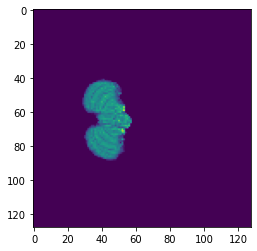

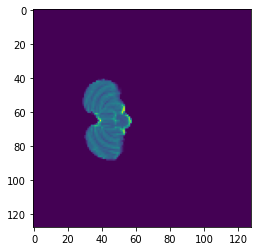

In [13]:
plt.imshow(data['image_flair'][4,0,:,:])
plt.figure()
plt.imshow(data['image_t2'][4,0,:,:])
# data['image_flair'].shape

In [11]:

brats_datapath = '/srv/Data/playground_data/brats/brats_training_data/data_raw/**/**.nii'
# brats_mask = '/srv/Data/playground_data/brats/brats_training_data/data_raw/**/**_seg.nii'

masklist , datalist = [],[]
for x in glob.glob(brats_datapath):
    if (x.split('/')[8].split('_')[-1]== 'seg.nii'):
        masklist.append({'label': x})
    else:
        datalist.append({'image':x})
        
h5cachedir_ = '/srv/Data/playground_data/brats/brats_training_data/h5_data'  
# datalist = {'image': '/srv/Data/playground_data/brats/brats_training_data/data_raw/BraTS20_Training_126/BraTS20_Training_126_flair.nii'}
h5cacheds = H5CachedDataset(datalist,masklist,transforms1,h5cachedir=h5cachedir_)
torch.multiprocessing.set_sharing_strategy('file_system')
brats_loader = torch.utils.data.DataLoader(h5cacheds,batch_size = 5 ,\
                                           shuffle = False,num_workers= 1)# ,pin_memory = True)


In [12]:
import matplotlib.pyplot as plt
for idx, data in enumerate(brats_loader):
    image=data['image']
    label=data['label']
    break
   

In [28]:
brats_datapath = '/srv/Data/playground_data/brats/brats_training_data/data_raw/**'
masklist , datalist = [], []
modality = ['t1', 't1ce', 't2', 'flair', 'seg']
for x in glob.glob(brats_datapath):
    print(x)
    patient_file = dict()
    i = np.random.randint(370)
    patient_path = x 
    
#     for i in range(len(modality)):
        
#     print(patient_path)

#     if (x.split('/')[8].split('_')[-1]== 'seg.nii'):
#           masklist.append({'label': x})
#     else:
#         modality = x.split('/')[8].split('_')[-1].split('.')[0]
        
        
#         datalist.append({modality:x})

/srv/Data/playground_data/brats/brats_training_data/data_raw/BraTS20_Training_126
/srv/Data/playground_data/brats/brats_training_data/data_raw/BraTS20_Training_231
/srv/Data/playground_data/brats/brats_training_data/data_raw/BraTS20_Training_118
/srv/Data/playground_data/brats/brats_training_data/data_raw/BraTS20_Training_213
/srv/Data/playground_data/brats/brats_training_data/data_raw/BraTS20_Training_320
/srv/Data/playground_data/brats/brats_training_data/data_raw/BraTS20_Training_151
/srv/Data/playground_data/brats/brats_training_data/data_raw/BraTS20_Training_352
/srv/Data/playground_data/brats/brats_training_data/data_raw/BraTS20_Training_289
/srv/Data/playground_data/brats/brats_training_data/data_raw/BraTS20_Training_344
/srv/Data/playground_data/brats/brats_training_data/data_raw/BraTS20_Training_129
/srv/Data/playground_data/brats/brats_training_data/data_raw/BraTS20_Training_103
/srv/Data/playground_data/brats/brats_training_data/data_raw/BraTS20_Training_300
/srv/Data/playgr

In [ ]:
### next task is to not provide all images at once but as t1list, t2list ....